In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from timeit import default_timer
from tqdm import tqdm
from torch import optim

from dataset import *
from model import *
from metrics import *
from utils import get_dataset, get_loader, process_data, down_sample, train_model

# label * mask
# 在训练时 label 和 target 仅提取非掩码值
# 如何从FNN的输出reshape为原来的形状？

In [2]:
def test_model(model, test_loader, device, args, metric_names=['MSE', 'RMSE', 'MaxError',]):
    '''
    test model
    
    '''
    k = args['model']['out_dim']  # k: depth

    # 创建字典，用于存储结果
    res_list_all = {}
    res_list_depth = {}
    res_list_seq = {}
    for name in metric_names:
        res_list_all[name] = []  
    
    # load model
    model_name = args['model']['model_name']
    saved_model_name = args["challenge_name"] + '_' + args['dataset']['region_name'] + '_' + model_name
    saved_path = os.path.join(args['saved_dir'], saved_model_name)
    print(f"Test mode, load checkpoint from {saved_path}-best.pt")
    checkpoint = torch.load(saved_path + "-best.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    
    # start testing
    model.eval()
    t1 = default_timer()  # start time

    with torch.no_grad():
        for inputs, targets, _, _, _ in test_loader:

            # prepare data
            if model_name == 'FNN':
                bs, depth, _, _ = targets.shape
                inputs, targets = process_data(inputs, targets, k, lstm = False)  # [bs, var, lat, lon] --> [bs, n]
            elif model_name == 'LSTM':
                bs, seq_len, depth, _, _ = targets.shape
                inputs, targets = process_data(inputs, targets, k, lstm = True)   # [bs, seq, var, lat, lon] --> [bs, seq, n]  torch.Size([1, 5, 16200])
            elif model_name == 'UNET':
                inputs, targets, _, _ = down_sample(inputs, targets)  # [bs, var, new_lat, new_lon]  torch.Size([1, 12, 27, 50]
                inputs, targets = inputs, targets[:, 0:k, ...]
            elif model_name == 'Earthformer':  # [1, 5, 12, 108, 200]
                inputs, targets, _, _ = down_sample(inputs, targets)
                inputs, targets = inputs.permute(0, 1, 3, 4, 2), targets[:, 0:k, ...].permute(0, 1, 3, 4, 2)
            else:
                raise NotImplementedError
            
            # evaluate
            inputs, targets = inputs.to(device) , targets.to(device)  
            pred = model(inputs)
            
            # 将 pred target 转化为[bs, seq, depth, -1]
            if model_name == 'LSTM':
                # torch.Size([bs, seq, n]) --> [bs, seq, depth, -1] 
                pred, targets = pred.reshape(bs, seq_len, depth, -1), targets.reshape(bs, seq_len, depth, -1)
            elif model_name == 'FNN':
                # torch.Size([bs, n]) --> [bs, 1, depth, -1] 
                pred, targets = pred.reshape(bs, depth, -1).unsqueeze(1), targets.reshape(bs, depth, -1).unsqueeze(1)
            elif model_name == 'UNET':
                # torch.Size([bs, depth, lat, lon]) --> [bs, 1, depth, -1]
                bs, depth, _, _ = targets.shape
                pred, targets = pred.reshape(bs, depth, -1).unsqueeze(1), targets.reshape(bs, depth, -1).unsqueeze(1)
            elif model_name == 'Earthformer': 
                # torch.Size([bs, seq, lat, lon, depth]) --> [bs, seq, depth, -1] 
                bs, seq_len, _, _, depth = targets.shape
                pred, targets = pred.reshape(bs, seq_len, -1, depth).permute(0, 1, 3, 2), targets.reshape(bs, seq_len, -1, depth).permute(0, 1, 3, 2)

            # calculate metrics
            res = calculate_res(pred, targets, metric_names)  # list of metrics  [bs, seq, depth]
            # print(res)
            for name in metric_names:
                res_list_all[name].append(res[name])

    for name in metric_names:
        # 在seq维度拼接起来
        res_list_all[name] = torch.concatenate(res_list_all[name])[0, ...]  # [seq_len, depth], bs = 1
        # 在拼接的维度求均值
        if name == 'MaxError':
            res_list_depth[name] = torch.max(res_list_all[name], dim=0).values  # [bs, depth]
            res_list_seq[name] = torch.max(res_list_all[name], dim=1).values  # [bs, seq]
            res_list_all[name] = torch.max(res_list_all[name])  
        else:
            res_list_depth[name] = torch.mean(res_list_all[name], dim=0)  # [depth]
            res_list_seq[name] = torch.mean(res_list_all[name], dim=1)  # [seq]
            res_list_all[name] = torch.mean(res_list_all[name])  
            

    t2 = default_timer()  # end time
    inference_time = (t2-t1)/len(test_loader.dataset)
    
    for name in metric_names:
        print(f"average {name}: {res_list_all[name]}")
        print(f"depth {name}: {res_list_depth[name].shape}")
        print(f"seq_len {name}: {res_list_seq[name]}")
    print(res_list_all)
    print("Testing time: {}".format(inference_time))

    
  
# LSTM：[batch_size, seq_len, n]
# FNN: [bs, n]
# UNET: [bs, var, lat, lon]
# earthformer: [bs, seq, var, lat, lon]

## Dataset

In [4]:
# 分割train val test
# FNN，seq_len = 0
# 按照年份分割数据

import yaml

config_file = './config/ST_Gulf_FNN.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([99, 12, 54, 100]) torch.Size([99, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohan

In [5]:
for data in train_loader:
    input = data[0]
    label = data[1]
    lat = data[2]
    lon = data[3]
    depth = data[4]
    print('input, label:', input.shape, label.shape)
    print('lat:', lat.shape, lon.shape)
    break

input, label: torch.Size([1, 12, 54, 100]) torch.Size([1, 36, 54, 100])
lat: torch.Size([1, 100]) torch.Size([1, 54])


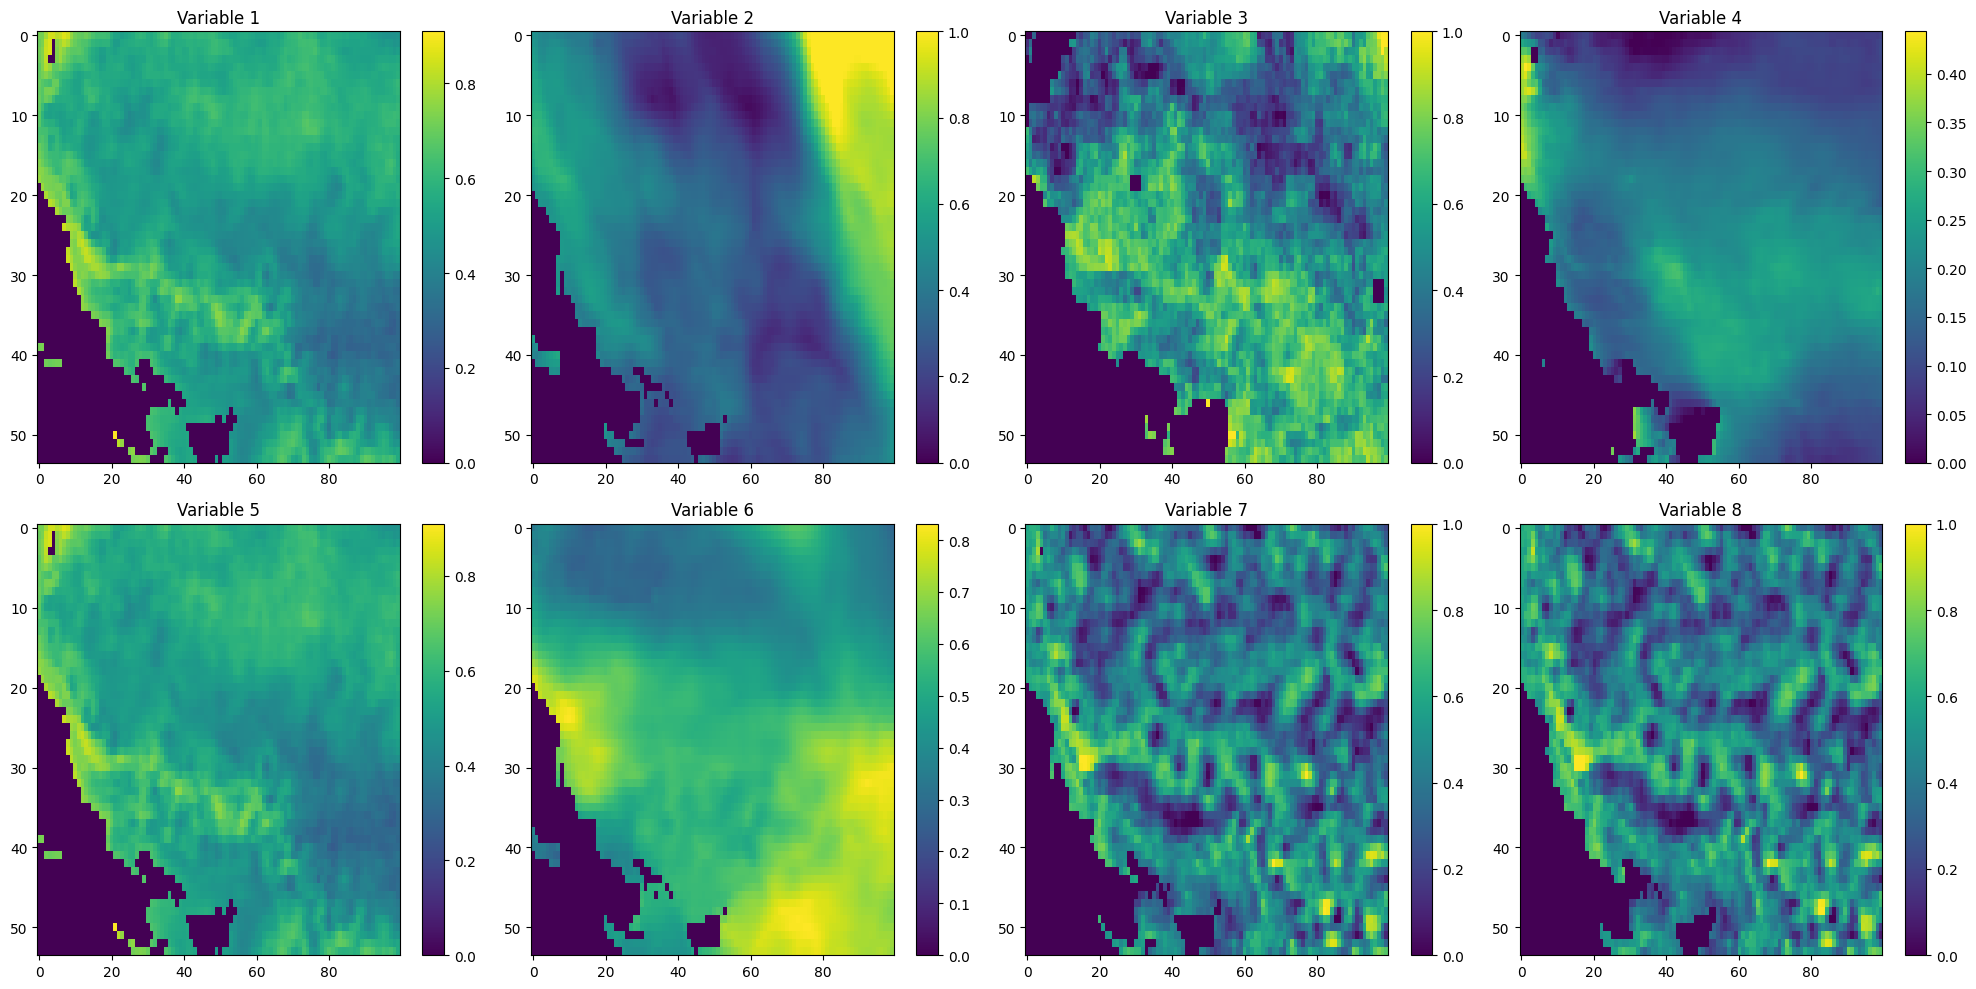

In [6]:
# 查看我的输入

def plot_ocean_data(data, i):
    data = data[i, ...]
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # 绘制每个变量
    for i in range(8):
        # print(data[i].shape)
        ax = axes[i // 4, i % 4]
        im = ax.imshow(data[i], aspect='auto')
        ax.set_title(f'Variable {i+1}')
        fig.colorbar(im, ax=ax)
        
        # 显示图像
    plt.tight_layout()
    plt.show()

plot_ocean_data(input, 0)

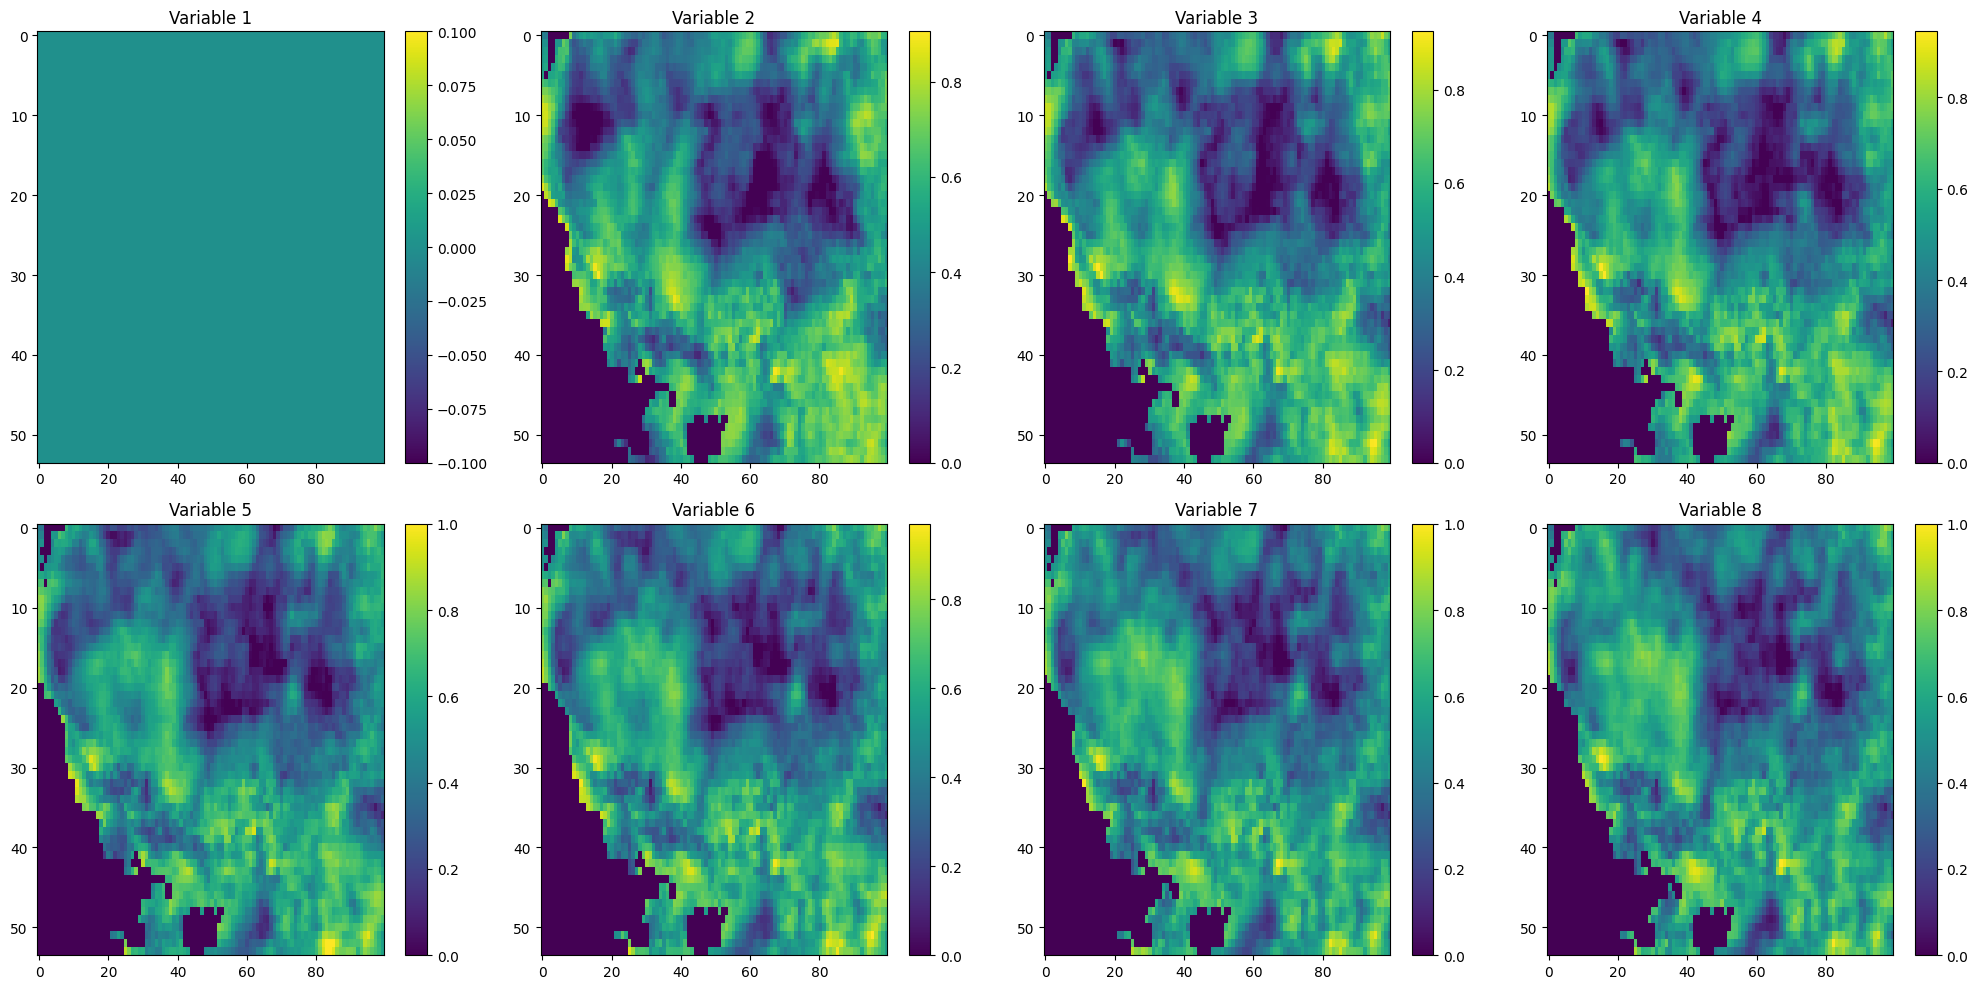

In [7]:
# 3 绘制前八个层
for i in range(label.shape[1]):
    data = label[0, i, ...]
    nan = np.isnan(data).reshape(-1)
    judge = all(item == 1 for item in nan)
    if judge:
        print(f'第{i+1}层全为nan')


plot_ocean_data(label, 0)

## LSTM

input:  (batch_size, seq_len, var\*lat*lon)  torch.Size([1, 5, 16200]) 

output: (batch_size, seq_len, depth\*lat*lon)  torch.Size([1, 5, 13500])



In [3]:
import yaml

config_file = './config/ST_Gulf_LSTM.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

for data in train_loader:
    input = data[0]
    label = data[1]
    mask = data[2]
    n_channels = input.shape[1]
    n_classes = label.shape[1]

    print('input, label:', input.shape, label.shape)
    print('mask: ', mask.shape)
    break

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([19, 5, 12, 54, 100]) torch.Size([19, 5, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/peng

In [7]:
# input, label: torch.Size([21, 5, 12, 108, 200]) torch.Size([21, 5, 36, 108, 200])
# after process:
# input, label: torch.Size([5, 270, 5, 12]) torch.Size([5, 270, 5, 3])

# LSTM输入数据：[batch_size, seq_len, input_size]

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k, lstm=True)
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']

model = LSTMModel(input_dim, output_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()


for inputs, targets, mask, _, _ in train_loader:
    inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
    # print('x, y: ', x.shape, y.shape, mask.shape)
    loss, pred, info = model.train_one_step(inputs, targets, mask, criterion, k)
    # print(loss)
    

In [6]:
# input, label: torch.Size([21, 5, 12, 108, 200]) torch.Size([21, 5, 36, 108, 200])
# after process:
# input, label: torch.Size([5, 270, 5, 12]) torch.Size([5, 270, 5, 3])

# LSTM输入数据：[batch_size, seq_len, input_size]

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k, lstm=True)
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']

model = LSTMModel(input_dim, output_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()


train_model_2(model, train_loader, val_loader, criterion, device, args)

 10%|█         | 1/10 [00:18<02:46, 18.47s/it]

Epoch 1/10, Training Loss: 0.0916, Validation Loss: 0.0553, Time: 1.51s


 20%|██        | 2/10 [00:37<02:32, 19.01s/it]

Epoch 2/10, Training Loss: 0.0587, Validation Loss: 0.0532, Time: 1.40s


 30%|███       | 3/10 [00:57<02:16, 19.51s/it]

Epoch 3/10, Training Loss: 0.0594, Validation Loss: 0.0531, Time: 1.40s


 40%|████      | 4/10 [01:18<01:58, 19.81s/it]

Epoch 4/10, Training Loss: 0.0597, Validation Loss: 0.0527, Time: 1.41s


 50%|█████     | 5/10 [01:19<01:05, 13.18s/it]

Epoch 5/10, Training Loss: 0.0600, Validation Loss: 0.0531, Time: 1.40s


 60%|██████    | 6/10 [01:21<00:36,  9.18s/it]

Epoch 6/10, Training Loss: 0.0607, Validation Loss: 0.0542, Time: 1.39s


 70%|███████   | 7/10 [01:22<00:19,  6.64s/it]

Epoch 7/10, Training Loss: 0.0613, Validation Loss: 0.0546, Time: 1.39s


 80%|████████  | 8/10 [01:23<00:09,  4.97s/it]

Epoch 8/10, Training Loss: 0.0617, Validation Loss: 0.0545, Time: 1.39s


 90%|█████████ | 9/10 [01:25<00:03,  3.86s/it]

Epoch 9/10, Training Loss: 0.0620, Validation Loss: 0.0546, Time: 1.39s


100%|██████████| 10/10 [01:26<00:00,  8.67s/it]

Epoch 10/10, Training Loss: 0.0619, Validation Loss: 0.0548, Time: 1.39s
avg_time : 1.40644


In [9]:
# input, label: torch.Size([21, 5, 12, 108, 200]) torch.Size([21, 5, 36, 108, 200])
# after process:
# input, label: torch.Size([5, 270, 5, 12]) torch.Size([5, 270, 5, 3])

# LSTM输入数据：[batch_size, seq_len, input_size]

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k, lstm=True)
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']

model = LSTMModel(input_dim, output_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()


train_model(model, train_loader, val_loader, criterion, device, args)

 10%|█         | 1/10 [00:19<02:51, 19.11s/it]

Epoch 1/10, Training Loss: 0.0975, Validation Loss: 0.0565, Time: 1.58s


 20%|██        | 2/10 [00:39<02:40, 20.00s/it]

Epoch 2/10, Training Loss: 0.0630, Validation Loss: 0.0556, Time: 1.41s


 30%|███       | 3/10 [00:41<01:20, 11.52s/it]

Epoch 3/10, Training Loss: 0.0624, Validation Loss: 0.0562, Time: 1.40s


 40%|████      | 4/10 [00:42<00:45,  7.53s/it]

Epoch 4/10, Training Loss: 0.0630, Validation Loss: 0.0564, Time: 1.40s


 50%|█████     | 5/10 [00:43<00:26,  5.33s/it]

Epoch 5/10, Training Loss: 0.0639, Validation Loss: 0.0560, Time: 1.40s


 60%|██████    | 6/10 [00:45<00:15,  4.00s/it]

Epoch 6/10, Training Loss: 0.0641, Validation Loss: 0.0566, Time: 1.40s


 70%|███████   | 7/10 [00:46<00:09,  3.15s/it]

Epoch 7/10, Training Loss: 0.0647, Validation Loss: 0.0575, Time: 1.40s


 80%|████████  | 8/10 [00:48<00:05,  2.60s/it]

Epoch 8/10, Training Loss: 0.0655, Validation Loss: 0.0578, Time: 1.40s


 90%|█████████ | 9/10 [00:49<00:02,  2.23s/it]

Epoch 9/10, Training Loss: 0.0658, Validation Loss: 0.0568, Time: 1.40s


100%|██████████| 10/10 [00:51<00:00,  5.11s/it]

Epoch 10/10, Training Loss: 0.0659, Validation Loss: 0.0590, Time: 1.46s
avg_time : 1.42297


In [10]:
device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k, lstm=True)
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']

model = LSTMModel(input_dim, output_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()

test_model(model, val_loader, device, args)

Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_LSTM-best.pt
average MSE: 0.055761583149433136
depth MSE: torch.Size([36])
seq_len MSE: tensor([0.0666, 0.0462, 0.0544, 0.0546, 0.0570], device='cuda:4')
average RMSE: 0.23169469833374023
depth RMSE: torch.Size([36])
seq_len RMSE: tensor([0.2473, 0.2147, 0.2280, 0.2311, 0.2373], device='cuda:4')
average MaxError: 1.2223858833312988
depth MaxError: torch.Size([36])
seq_len MaxError: tensor([1.2224, 1.0683, 1.0101, 1.0522, 0.9676], device='cuda:4')
{'MSE': tensor(0.0558, device='cuda:4'), 'RMSE': tensor(0.2317, device='cuda:4'), 'MaxError': tensor(1.2224, device='cuda:4')}
Testing time: 0.0432858020067215


## FNN

input:  (batch_size, var\*lat*lon)  torch.Size([1, 16200]) 

output: (batch_size, depth\*lat*lon)  torch.Size([1, 13500])

In [2]:
import yaml

config_file = './config/ST_Gulf_FNN.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

for data in train_loader:
    input = data[0]
    label = data[1]
    mask = data[2]
    lon = data[3]
    depth = data[4]
    n_channels = input.shape[1]
    n_classes = label.shape[1]

    print('input, label:', input.shape, label.shape)
    print('mask:', mask.shape, mask)
    break

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc


TypeError: len() of unsized object

In [5]:
device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']  # depth
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k)
    in_dim = inputs.shape[1]
    out_dim = targets.shape[1]
    print(in_dim, targets.shape)
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']
model = FFNN(in_dim, out_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()

for inputs, targets, mask, _, _ in train_loader:
    inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
    loss, pred, info = model.train_one_step(inputs, targets, mask, criterion, k)
    # print(loss)

64800 torch.Size([1, 194400])


In [13]:
device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']  # depth
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k)
    in_dim = inputs.shape[1]
    out_dim = targets.shape[1]
    print(in_dim, targets.shape)
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']
model = FFNN(in_dim, out_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()

train_model_2(model, train_loader, val_loader, criterion, device, args)


64800 torch.Size([1, 194400])


 10%|█         | 1/10 [00:14<02:10, 14.53s/it]

Epoch 1/10, Training Loss: 0.0531, Validation Loss: 0.0528, Time: 3.67s


 20%|██        | 2/10 [00:28<01:54, 14.32s/it]

Epoch 2/10, Training Loss: 0.0465, Validation Loss: 0.0451, Time: 3.66s


 30%|███       | 3/10 [00:32<01:06,  9.47s/it]

Epoch 3/10, Training Loss: 0.0447, Validation Loss: 0.0490, Time: 3.67s


 40%|████      | 4/10 [00:46<01:08, 11.35s/it]

Epoch 4/10, Training Loss: 0.0450, Validation Loss: 0.0432, Time: 3.65s


 50%|█████     | 5/10 [00:50<00:42,  8.59s/it]

Epoch 5/10, Training Loss: 0.0432, Validation Loss: 0.0463, Time: 3.65s


 60%|██████    | 6/10 [00:54<00:27,  6.92s/it]

Epoch 6/10, Training Loss: 0.0432, Validation Loss: 0.0464, Time: 3.65s


 70%|███████   | 7/10 [00:57<00:17,  5.86s/it]

Epoch 7/10, Training Loss: 0.0427, Validation Loss: 0.0433, Time: 3.65s


 80%|████████  | 8/10 [01:01<00:10,  5.16s/it]

Epoch 8/10, Training Loss: 0.0433, Validation Loss: 0.0449, Time: 3.64s


 90%|█████████ | 9/10 [01:05<00:04,  4.70s/it]

Epoch 9/10, Training Loss: 0.0439, Validation Loss: 0.0437, Time: 3.64s


100%|██████████| 10/10 [01:08<00:00,  6.87s/it]

Epoch 10/10, Training Loss: 0.0424, Validation Loss: 0.0480, Time: 3.65s
avg_time : 3.65367


In [14]:
device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']  # depth
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k)
    in_dim = inputs.shape[1]
    out_dim = targets.shape[1]
    print(in_dim, targets.shape)
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']
model = FFNN(in_dim, out_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()

train_model(model, train_loader, val_loader, criterion, device, args)


64800 torch.Size([1, 194400])


 10%|█         | 1/10 [00:14<02:08, 14.23s/it]

Epoch 1/10, Training Loss: 0.0533, Validation Loss: 0.0508, Time: 3.66s


 20%|██        | 2/10 [00:28<01:55, 14.38s/it]

Epoch 2/10, Training Loss: 0.0453, Validation Loss: 0.0440, Time: 3.64s


 30%|███       | 3/10 [00:32<01:06,  9.49s/it]

Epoch 3/10, Training Loss: 0.0468, Validation Loss: 0.0456, Time: 3.64s


 40%|████      | 4/10 [00:36<00:43,  7.19s/it]

Epoch 4/10, Training Loss: 0.0466, Validation Loss: 0.0499, Time: 3.64s


 50%|█████     | 5/10 [00:39<00:29,  5.92s/it]

Epoch 5/10, Training Loss: 0.0442, Validation Loss: 0.0466, Time: 3.64s


 60%|██████    | 6/10 [00:43<00:20,  5.15s/it]

Epoch 6/10, Training Loss: 0.0428, Validation Loss: 0.0464, Time: 3.62s


 70%|███████   | 7/10 [00:47<00:13,  4.66s/it]

Epoch 7/10, Training Loss: 0.0439, Validation Loss: 0.0513, Time: 3.63s


 80%|████████  | 8/10 [01:00<00:14,  7.35s/it]

Epoch 8/10, Training Loss: 0.0446, Validation Loss: 0.0413, Time: 3.63s


 90%|█████████ | 9/10 [01:03<00:06,  6.20s/it]

Epoch 9/10, Training Loss: 0.0437, Validation Loss: 0.0474, Time: 3.65s


100%|██████████| 10/10 [01:07<00:00,  6.75s/it]

Epoch 10/10, Training Loss: 0.0436, Validation Loss: 0.0436, Time: 3.63s
avg_time : 3.63913


In [13]:
test_model(model, val_loader, device, args)

Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_FNN-best.pt
average MSE: 0.030616654083132744
depth MSE: torch.Size([36])
seq_len MSE: tensor([0.0306], device='cuda:4')
average RMSE: 0.17439597845077515
depth RMSE: torch.Size([36])
seq_len RMSE: tensor([0.1744], device='cuda:4')
average MaxError: 0.8854683041572571
depth MaxError: torch.Size([36])
seq_len MaxError: tensor([0.8855], device='cuda:4')
{'MSE': tensor(0.0306, device='cuda:4'), 'RMSE': tensor(0.1744, device='cuda:4'), 'MaxError': tensor(0.8855, device='cuda:4')}
Testing time: 0.002532372623682022


## UNet

input:  (batch_size, var, lat, lon)  torch.Size([1, 12, 108, 200])

output:  (batch_size, depth, lat, lon)   torch.Size([1, 36, 108, 200])



In [8]:
import yaml

config_file = './config/ST_Gulf_UNET.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

for data in train_loader:
    input = data[0]
    label = data[1]
    lat = data[2]
    lon = data[3]
    depth = data[4]
    n_channels = input.shape[1]
    n_classes = label.shape[1]

    print('input, label:', input.shape, label.shape)
    print('lat:', lat.shape, lon.shape)
    break

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([99, 12, 54, 100]) torch.Size([99, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohan

In [13]:
device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')

n_channels = args['model']['in_dim']
n_classes = args['model']['out_dim']

model = UNet(n_channels, n_classes, bilinear=False).to(device)
criterion = nn.MSELoss()


for inputs, targets, mask, _, _ in train_loader:
    inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
    loss, pred, info = model.train_one_step(inputs, targets, mask, criterion, k)
    # print(loss)


In [16]:
device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')

n_channels = args['model']['in_dim']
n_classes = args['model']['out_dim']

model = UNet(n_channels, n_classes, bilinear=False).to(device)
criterion = nn.MSELoss()


train_model_2(model, train_loader, val_loader, criterion, device, args)


 10%|█         | 1/10 [00:01<00:15,  1.69s/it]

Epoch 1/10, Training Loss: 0.1021, Validation Loss: 22.2175, Time: 1.17s


 20%|██        | 2/10 [00:03<00:12,  1.60s/it]

Epoch 2/10, Training Loss: 0.0448, Validation Loss: 0.0477, Time: 1.12s


 30%|███       | 3/10 [00:04<00:11,  1.58s/it]

Epoch 3/10, Training Loss: 0.0419, Validation Loss: 0.0461, Time: 1.12s


 40%|████      | 4/10 [00:06<00:09,  1.54s/it]

Epoch 4/10, Training Loss: 0.0402, Validation Loss: 0.0450, Time: 1.06s


 50%|█████     | 5/10 [00:07<00:07,  1.57s/it]

Epoch 5/10, Training Loss: 0.0388, Validation Loss: 0.0441, Time: 1.14s


 60%|██████    | 6/10 [00:08<00:05,  1.41s/it]

Epoch 6/10, Training Loss: 0.0377, Validation Loss: 0.0453, Time: 1.06s


 70%|███████   | 7/10 [00:10<00:04,  1.35s/it]

Epoch 7/10, Training Loss: 0.0368, Validation Loss: 0.0466, Time: 1.16s


 80%|████████  | 8/10 [00:11<00:02,  1.30s/it]

Epoch 8/10, Training Loss: 0.0359, Validation Loss: 0.0480, Time: 1.15s


 90%|█████████ | 9/10 [00:12<00:01,  1.25s/it]

Epoch 9/10, Training Loss: 0.0352, Validation Loss: 0.0533, Time: 1.12s


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Epoch 10/10, Training Loss: 0.0346, Validation Loss: 0.0621, Time: 1.16s
avg_time : 1.12608


In [15]:
device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')

n_channels = args['model']['in_dim']
n_classes = args['model']['out_dim']

model = UNet(n_channels, n_classes, bilinear=False).to(device)
criterion = nn.MSELoss()


train_model(model, train_loader, val_loader, criterion, device, args)


 10%|█         | 1/10 [00:01<00:16,  1.83s/it]

Epoch 1/10, Training Loss: 0.0944, Validation Loss: 0.0512, Time: 1.34s


 20%|██        | 2/10 [00:03<00:13,  1.65s/it]

Epoch 2/10, Training Loss: 0.0429, Validation Loss: 0.0573, Time: 1.47s


 30%|███       | 3/10 [00:04<00:11,  1.63s/it]

Epoch 3/10, Training Loss: 0.0378, Validation Loss: 0.0514, Time: 1.55s


 40%|████      | 4/10 [00:06<00:10,  1.75s/it]

Epoch 4/10, Training Loss: 0.0350, Validation Loss: 0.0475, Time: 1.30s


 50%|█████     | 5/10 [00:08<00:07,  1.55s/it]

Epoch 5/10, Training Loss: 0.0334, Validation Loss: 0.0507, Time: 1.14s


 60%|██████    | 6/10 [00:09<00:05,  1.42s/it]

Epoch 6/10, Training Loss: 0.0322, Validation Loss: 0.0499, Time: 1.13s


 70%|███████   | 7/10 [00:10<00:04,  1.34s/it]

Epoch 7/10, Training Loss: 0.0313, Validation Loss: 0.0605, Time: 1.13s


 80%|████████  | 8/10 [00:11<00:02,  1.29s/it]

Epoch 8/10, Training Loss: 0.0305, Validation Loss: 0.0515, Time: 1.13s


 90%|█████████ | 9/10 [00:12<00:01,  1.25s/it]

Epoch 9/10, Training Loss: 0.0297, Validation Loss: 0.0486, Time: 1.11s


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

Epoch 10/10, Training Loss: 0.0291, Validation Loss: 0.0497, Time: 1.12s
avg_time : 1.24258


In [16]:
test_model(model, val_loader, device, args)

Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_UNET-best.pt
average MSE: 0.0617300420999527
depth MSE: torch.Size([36])
seq_len MSE: tensor([0.0617], device='cuda:4')
average RMSE: 0.23418694734573364
depth RMSE: torch.Size([36])
seq_len RMSE: tensor([0.2342], device='cuda:4')
average MaxError: 0.9431772232055664
depth MaxError: torch.Size([36])
seq_len MaxError: tensor([0.9432], device='cuda:4')
{'MSE': tensor(0.0617, device='cuda:4'), 'RMSE': tensor(0.2342, device='cuda:4'), 'MaxError': tensor(0.9432, device='cuda:4')}
Testing time: 0.007130382023751736


## Earthformer

input:  (batch_size, seq_le, lat, lon, var)  (B, T, H, W, C)

output:  (batch_size, seq_len, lat, lon, depth)   (B, T_out, H, W, C_out)



In [17]:
import yaml

config_file = './config/ST_Gulf_Earthformer.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

for data in train_loader:
    input = data[0]
    label = data[1]
    lat = data[2]
    lon = data[3]
    depth = data[4]
    n_channels = input.shape[1]
    n_classes = label.shape[1]

    print('input, label:', input.shape, label.shape)
    print('lat:', lat.shape, lon.shape)
    break

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([19, 5, 12, 54, 100]) torch.Size([19, 5, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/peng

In [29]:
# input Shape (B, T, H, W, var)
# output Shape (B, T_out, H, W, depth)

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")

k = args['model']['out_dim']
data = next(iter(train_loader))
# inputs, targets, _, _ = down_sample(data[0], data[1])  # 降为1*1网格  torch.Size([1, 5, 12, 27, 50])
# inputs, targets = data[0], data[1]
inputs = inputs.permute(0, 1, 3, 4, 2)
labels = targets[:, 0:k, ...].permute(0, 1, 3, 4, 2)
input_shape = inputs.shape[1:]
target_shape = labels.shape[1:]
print('after down sample: ', input_shape, target_shape)

base_units = args['model']['base_units']
downsample_scale = args['model']['downsample_scale']
model = TransformerModel(input_shape,
                 target_shape,
                 base_units=base_units,
                 downsample_scale=downsample_scale,
                 pos_embed_type = "t+h+w",
                 z_init_method='nearest_interp',
                 block_units=None).to(device)


criterion = nn.MSELoss()

for inputs, targets, mask, _, _ in train_loader:
    inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
    loss, pred, info = model.train_one_step(inputs, targets, mask, criterion, k)
    # print(loss)

# after down sample:  torch.Size([5, 108, 200, 12]) torch.Size([5, 1s08, 200, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# PatchMerging3D:  torch.Size([1, 5, 108, 200, 64]) 1 5 108 200 64

# 降分辨率为1*1
# 出错
# after down sample:  torch.Size([5, 27, 50, 12]) torch.Size([5, 27, 50, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 27, 50]) torch.Size([1, 5, 36, 27, 50])
# PatchMerging3D:  torch.Size([1, 5, 27, 51, 64]) 1 5 28 50 64

# 降分辨率为0.5*0.5
# after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 54, 100]) torch.Size([1, 5, 36, 54, 100])
# PatchMerging3D:  torch.Size([1, 5, 54, 100, 64]) 1 5 54 100 64


after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])


In [30]:
# input Shape (B, T, H, W, var)
# output Shape (B, T_out, H, W, depth)

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")

k = args['model']['out_dim']
data = next(iter(train_loader))
# inputs, targets, _, _ = down_sample(data[0], data[1])  # 降为1*1网格  torch.Size([1, 5, 12, 27, 50])
# inputs, targets = data[0], data[1]
inputs = inputs.permute(0, 1, 3, 4, 2)
labels = targets[:, 0:k, ...].permute(0, 1, 3, 4, 2)
input_shape = inputs.shape[1:]
target_shape = labels.shape[1:]
print('after down sample: ', input_shape, target_shape)

base_units = args['model']['base_units']
downsample_scale = args['model']['downsample_scale']
model = TransformerModel(input_shape,
                 target_shape,
                 base_units=base_units,
                 downsample_scale=downsample_scale,
                 pos_embed_type = "t+h+w",
                 z_init_method='nearest_interp',
                 block_units=None).to(device)


criterion = nn.MSELoss()

train_model_2(model, train_loader, val_loader, criterion, device, args)

# after down sample:  torch.Size([5, 108, 200, 12]) torch.Size([5, 1s08, 200, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# PatchMerging3D:  torch.Size([1, 5, 108, 200, 64]) 1 5 108 200 64

# 降分辨率为1*1
# 出错
# after down sample:  torch.Size([5, 27, 50, 12]) torch.Size([5, 27, 50, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 27, 50]) torch.Size([1, 5, 36, 27, 50])
# PatchMerging3D:  torch.Size([1, 5, 27, 51, 64]) 1 5 28 50 64

# 降分辨率为0.5*0.5
# after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 54, 100]) torch.Size([1, 5, 36, 54, 100])
# PatchMerging3D:  torch.Size([1, 5, 54, 100, 64]) 1 5 54 100 64


  0%|          | 0/10 [00:00<?, ?it/s]

after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])


 10%|█         | 1/10 [00:00<00:08,  1.12it/s]

Epoch 1/10, Training Loss: 0.1422, Validation Loss: 0.0586, Time: 0.80s


 20%|██        | 2/10 [00:01<00:07,  1.03it/s]

Epoch 2/10, Training Loss: 0.0590, Validation Loss: 0.0568, Time: 0.73s


 30%|███       | 3/10 [00:02<00:07,  1.00s/it]

Epoch 3/10, Training Loss: 0.0568, Validation Loss: 0.0530, Time: 0.90s


 40%|████      | 4/10 [00:04<00:06,  1.07s/it]

Epoch 4/10, Training Loss: 0.0555, Validation Loss: 0.0521, Time: 1.05s


 50%|█████     | 5/10 [00:05<00:05,  1.11s/it]

Epoch 5/10, Training Loss: 0.0548, Validation Loss: 0.0514, Time: 1.04s


 60%|██████    | 6/10 [00:06<00:04,  1.13s/it]

Epoch 6/10, Training Loss: 0.0543, Validation Loss: 0.0512, Time: 1.03s


 70%|███████   | 7/10 [00:07<00:03,  1.04s/it]

Epoch 7/10, Training Loss: 0.0543, Validation Loss: 0.0520, Time: 0.83s


 80%|████████  | 8/10 [00:08<00:01,  1.00it/s]

Epoch 8/10, Training Loss: 0.0539, Validation Loss: 0.0492, Time: 0.81s


 90%|█████████ | 9/10 [00:09<00:00,  1.04it/s]

Epoch 9/10, Training Loss: 0.0551, Validation Loss: 0.0525, Time: 0.84s


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]

Epoch 10/10, Training Loss: 0.0552, Validation Loss: 0.0525, Time: 0.81s
avg_time : 0.88407


In [33]:
# input Shape (B, T, H, W, var)
# output Shape (B, T_out, H, W, depth)

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")

k = args['model']['out_dim']
data = next(iter(train_loader))
# inputs, targets, _, _ = down_sample(data[0], data[1])  # 降为1*1网格  torch.Size([1, 5, 12, 27, 50])
# inputs, targets = data[0], data[1]
inputs = inputs.permute(0, 1, 3, 4, 2)
labels = targets[:, 0:k, ...].permute(0, 1, 3, 4, 2)
input_shape = inputs.shape[1:]
target_shape = labels.shape[1:]
print('after down sample: ', input_shape, target_shape)

base_units = args['model']['base_units']
downsample_scale = args['model']['downsample_scale']
model = TransformerModel(input_shape,
                 target_shape,
                 base_units=base_units,
                 downsample_scale=downsample_scale,
                 pos_embed_type = "t+h+w",
                 z_init_method='nearest_interp',
                 block_units=None).to(device)


criterion = nn.MSELoss()

train_model(model, train_loader, val_loader, criterion, device, args)

# after down sample:  torch.Size([5, 108, 200, 12]) torch.Size([5, 1s08, 200, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# PatchMerging3D:  torch.Size([1, 5, 108, 200, 64]) 1 5 108 200 64

# 降分辨率为1*1
# 出错
# after down sample:  torch.Size([5, 27, 50, 12]) torch.Size([5, 27, 50, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 27, 50]) torch.Size([1, 5, 36, 27, 50])
# PatchMerging3D:  torch.Size([1, 5, 27, 51, 64]) 1 5 28 50 64

# 降分辨率为0.5*0.5
# after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 54, 100]) torch.Size([1, 5, 36, 54, 100])
# PatchMerging3D:  torch.Size([1, 5, 54, 100, 64]) 1 5 54 100 64


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])
Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/pengguohang/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2957919/2058277487.py", line 29, in <module>
    train_model(model, train_loader, val_loader, criterion, device, args)
  File "/home/pengguohang/python_test/Ocean/OceanBench/utils.py", line 182, in train_model
  File "/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_2957919/1065662418.py", line 76, in forward
    x = self.initial_encoder(x)  # 卷积层 + 下采样   (B, T_new, H_new, W_new, C_new)   torch.Size([1, 5, 54, 100, 64])
  File "/home/pengguohang/a

In [ ]:
test_model(model, test_loader, device, args)

Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_Earthformer-best.pt
average MSE: 0.06060119345784187
depth MSE: torch.Size([36])
seq_len MSE: tensor([0.0506, 0.0649, 0.0630, 0.0636, 0.0609], device='cuda:4')
average RMSE: 0.2421565055847168
depth RMSE: torch.Size([36])
seq_len RMSE: tensor([0.2244, 0.2488, 0.2476, 0.2476, 0.2424], device='cuda:4')
average MaxError: 1.0368815660476685
depth MaxError: torch.Size([36])
seq_len MaxError: tensor([0.9218, 0.9048, 0.8930, 0.9761, 1.0369], device='cuda:4')
{'MSE': tensor(0.0606, device='cuda:4'), 'RMSE': tensor(0.2422, device='cuda:4'), 'MaxError': tensor(1.0369, device='cuda:4')}
Testing time: 0.02413866203278303


## OSNet



In [ ]:
a = 440640 / 64
b = a / 25
b

275.4